## Interpretation of models trained on HEV ORF 1 dataset for multiclass classification

### Dataset: HEV sequences: ORF 1
### Sequences aligned using MAFFT

**Models**: FNN, CNN, RNN, LSTM, TF

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**:

**Classification**: Multi-class

**\# classes**: 3 (Human, Boar, Others)

**\# ORF1 (n=954)**
***train=763, val=95, test=96***


In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/hev-aligned',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/hev-aligned/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/hev-aligned/../../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/hev-aligned/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/hev-aligned/..']

In [2]:
from models.nlp.transformer import transformer, transformer_model
from models.nlp import cnn1d, lstm
from models.nlp.fnn import fnn
from datasets.protein_sequence_dataset import ProteinSequenceDataset
from src.utils import utils, nn_utils
from models.nlp.embedding.padding import Padding

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve
from statistics import mean

from captum.attr import LayerIntegratedGradients, TokenReferenceBase, LayerGradientXActivation, LayerDeepLift, LayerLRP

In [3]:
label_groupings = {
                    "Human": [ "Human" ],
                    "Boar": [ "Boar" ],
                    "Others": [ "*" ] # Leporidae", "Rodent", "Avian", "Ferret", "Camel", "Mongoose", "Bat", "Primate", "Shrew", "Deer", "Hare", "Canine" ]
                    }

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26, '-': 0}
idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}

train_sequence_settings =  {
    "sequence_col": "sequence",
    "batch_size": 16,
    "max_sequence_length": 2481,
    "pad_sequence_val": 0,
    "truncate": True,
    "feature_type": "token"
}

test_sequence_settings =  train_sequence_settings.copy()
test_sequence_settings["batch_size"] = 1

label_settings = {
    "label_col": "host",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "max_seq_len": 2481,
    "loss": "CrossEntropyLoss",
    "with_convolution": False,
    "n_heads": 8,
    "depth": 6,
    "n_tokens": 27,
    "n_classes": 3,
    "n_epochs": 10,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024
}

### Load the datasets

In [4]:
def get_token_dataset_loader(df, sequence_settings, label_settings):
    label_col = label_settings["label_col"]
    
    seq_col = sequence_settings["sequence_col"]
    batch_size = sequence_settings["batch_size"]
    max_seq_len = sequence_settings["max_sequence_length"]
    pad_sequence_val = sequence_settings["pad_sequence_val"]
    truncate = sequence_settings["truncate"]
    
    df = df[[seq_col, label_col]]
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")
    
    dataset = ProteinSequenceDataset(df, seq_col, max_seq_len, truncate, label_col)
    return index_label_map, DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,
                      collate_fn=Padding(max_seq_len, pad_sequence_val))

def print_dataset_loader(dataset_loader):
    sequence, label = next(iter(dataset_loader))
    print(f"Sequence tensor size = {sequence.shape}")
    print(f"Sequence = {sequence}")
    print(f"Label tensor size = {label.shape}")
    print(f"Label = {label}")
    
def get_aligned_seq_pos_mapping(seq):
    aligned_seq_pos_map = {}
    token_count = 0
    for i, token in enumerate(seq):
        if token == 0:
            aligned_seq_pos_map[i] = 0
        else:
            token_count += 1
            aligned_seq_pos_map[i] = token_count
    return aligned_seq_pos_map

In [5]:
hev_df = pd.read_csv("/home/grads/blessyantony/dev/git/zoonosis/input/data/hev/aligned/hev_orf1_alignment_ba.fasta_processed.csv")
hev_df

,id,region,host,genotype,host-genotype,sequence
0,QJQ50412.1,ORF1,Avian,unknown,Avian-unknown,-MDVSQFAESKGVKTALEAAALAAANTALRNARVVTPYLTQQQTKN...
1,UNQ84074.1,ORF1,Avian,unknown,Avian-unknown,-MDVSQFAESKGVKTALEAAALAAANTALRNARVVTPYLTQQQTKN...
2,AAS45830.1,ORF1,Avian,unknown,Avian-unknown,-MDVSQFAESKGVKTALEAAALAAANTALRNARVVTPYLTQQQTKN...
3,YP_009001465.1,ORF1,Avian,unknown,Avian-unknown,-MDVSQFAESKGVKTALEAAALAAANTALRNARVVTPYLTQQQTKN...
4,UFQ90535.1,ORF1,Avian,unknown,Avian-unknown,-MDVSQFAESKGVKTALEAAALAAANTALRNARVVTPYLTQQQTKN...
...,...,...,...,...,...,...
949,AAA45732.1,ORF1,Unknown,HEV2,Unknown-HEV2,----------------------------------------------...
950,AAA45736.1,ORF1,Unknown,HEV1,Unknown-HEV1,----------------------------------------------...
951,AAS45831.1,ORF1,Avian,unknown,Avian-unknown,----------------------------------------------...
952,YP_009001467.1,ORF1,Avian,unknown,Avian-unknown,----------------------------------------------...


In [6]:
hev_df["host"].value_counts()

Human                                698
Boar                                 118
Leporidae                             38
Rodent                                30
Unknown                               19
Avian                                 16
Camel                                  8
Ferret                                 8
culture supernatant (Unknown map)      4
Mongoose                               3
Primate                                3
Bat                                    3
Deer                                   2
Shrew                                  2
Canine                                 1
Hare                                   1
Name: host, dtype: int64

In [7]:
def get_target_dataset_loader(target):
    hev_target_df = hev_df[hev_df[label_settings["label_col"]] == target]
    print(f"Size {target} df = {hev_target_df.shape}")
    return get_token_dataset_loader(hev_target_df, test_sequence_settings, label_settings)

In [8]:
index_label_map, hev_dataset_loader = get_token_dataset_loader(hev_df, test_sequence_settings, label_settings)

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/hev-aligned/../../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/hev-aligned/../../../../src/utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/hev-aligned/../../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to

### Load the trained models

#### Model: TF trained on Coronaviridae S protein dataset
#### Training Dataset: HEV ORF 2 (hev_orf2_alignment_ba.fasta_processed.csv)
#### max sequence length: 794


In [9]:
models_dir = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/hev/20231012/host_multi_e50/orf1"

#### CNN Model

In [10]:
model["kernel_size"] = 3
model["stride"] = 1
model["depth"] = 4
cnn_model = cnn1d.get_cnn_model(model)
cnn_model.load_state_dict(torch.load(os.path.join(models_dir, "cnn-l_4-lr1e-3-orf1_itr0.pth")))
cnn_model = cnn_model.to(nn_utils.get_device())
cnn_model.eval()
cnn_model.zero_grad()

CNN_1D_VirusHostPrediction(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (conv1d): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
  (conv1d_hidden): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,))
  (conv1d_hidden_layers): ModuleList(
    (0-2): 3 x Conv1d(1024, 1024, kernel_size=(3,), stride=(1,))
  )
  (linear): Linear(in_features=1024, out_features=3, bias=True)
)
Number of parameters =  14177795


#### LSTM Model

In [11]:
model["depth"] = 2
lstm_model = lstm.get_lstm_model(model)
lstm_model.load_state_dict(torch.load(os.path.join(models_dir, "lstm-l_2-lr1e-3-orf1_itr0.pth")))
lstm_model = lstm_model.to(nn_utils.get_device())

LSTM_VirusHostPrediction(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (lstm): LSTM(512, 1024, num_layers=2, batch_first=True)
  (linear): Linear(in_features=1024, out_features=3, bias=True)
)
Number of parameters =  14713347


#### TF - Custom Model

In [12]:
model["depth"] = 6
tf_custom_model = transformer.get_transformer_model(model)
tf_custom_model.load_state_dict(torch.load(os.path.join(models_dir, "transformer-l_6-h_8-lr1e-4-orf1_itr0.pth")))
tf_custom_model = tf_custom_model.to(nn_utils.get_device())
tf_custom_model.eval()
tf_custom_model.zero_grad()

Transformer(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=1024, bias=True)
          (W_2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
        )
      )
    )
    (norm): NormalizationLayer()
  )
  (linear): Linear(in_features=512, out_features=3, b

### Prediction Performance

In [13]:
def validate(model, dataset_loader):
    with torch.no_grad():
        model.eval()

        results = []

        for _, data in enumerate(dataset_loader):
            # get input and labels; data is a list of [(inputs, labels)]
            inputs, labels = data

            output = model(inputs)

            # tensorboard + logs

            # to get probabilities of the output
            output = F.softmax(output, dim=-1)
            result_df = pd.DataFrame(output.cpu().numpy())
            result_df["y_true"] = labels.cpu().numpy()
            results.append(result_df)
    
    return pd.concat(results, ignore_index=True)

In [14]:
results = validate(tf_custom_model, hev_dataset_loader)

In [15]:
results_df = results.rename(columns=index_label_map)
results_df["y_true"] = results_df["y_true"].map(lambda x: index_label_map[x])
results_df

,Boar,Human,Others,y_true
0,0.002466,0.231411,0.766123,Others
1,0.000071,0.110287,0.889642,Others
2,0.421554,0.268850,0.309596,Boar
3,0.348093,0.646359,0.005547,Human
4,0.349096,0.645423,0.005481,Human
...,...,...,...,...
949,0.703822,0.282815,0.013363,Boar
950,0.078563,0.705685,0.215753,Human
951,0.703532,0.283066,0.013402,Boar
952,0.002094,0.173184,0.824722,Others


In [16]:
auprcs = []
for i in index_label_map.values():
    precision, recall, _ = precision_recall_curve(y_true=results_df["y_true"].values, probas_pred=results_df[i].values, pos_label=i)
    auprc = auc(recall, precision)
    print(f"AUPRC for class {i} = {auprc}")
    auprcs.append(auprc)

macro_auprc = mean(auprcs)
print(f"Macro AUPRC = {macro_auprc}")

AUPRC for class Boar = 0.4604933269260953
AUPRC for class Human = 0.9487475045302458
AUPRC for class Others = 0.8967161999325725
Macro AUPRC = 0.7686523437963045


## Intepretation

In [17]:
def compute_top_n_positions(attr_df, n):
    attr_rank_df = attr_df.abs().rank("columns", ascending=False).astype(int)
    # retain only top n ranks
    attr_rank_df[attr_rank_df > n] = None
    # drop all columns (positions) with all NaN i.e. this position is not in the top 10 for any sequence
    attr_rank_df.dropna(axis=1, how="all", inplace=True)
    print(attr_rank_df.columns)
    print(attr_rank_df.head(20))
    sns.heatmap(data=attr_df[attr_rank_df.columns])
    plt.show()

#### Inputs

In [18]:
human_inputs = []
_, human_dataset_loader = get_target_dataset_loader("Human")
for i in range(20):
    human_inputs.append(next(iter(human_dataset_loader)))
    
boar_inputs = []
_, boar_dataset_loader = get_target_dataset_loader("Boar")
for i in range(20):
    boar_inputs.append(next(iter(boar_dataset_loader)))

Size Human df = (698, 6)
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Size Boar df = (118, 6)
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/hev-aligned/../../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/hev-aligned/../../../../src/utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/hev-aligned/../../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to

In [19]:
human_input = next(iter(human_dataset_loader))
boar_input = next(iter(boar_dataset_loader))

In [20]:
human_seq, _ = human_input
human_seq_detach = human_seq.detach().cpu().numpy()[0]
human_input_seq_pos_map = get_aligned_seq_pos_mapping(human_seq_detach)

#### Outputs

In [21]:
n_attr_dfs = []
single_seq_attr_dfs = []

### LayerGradientXActivation

In [22]:
def compute_lgxa_attributions(model, inputs, target):
    attributions = []
    for seq, label in inputs:
        interpreter = LayerGradientXActivation(model, model.embedding)
        attribution = interpreter.attribute(seq, target=target)
        
        attribution = attribution.sum(dim=2).squeeze(0)
        attribution = attribution / torch.norm(attribution)
        attributions.append(attribution.detach().cpu().numpy())
    return pd.DataFrame(attributions)

In [23]:
n_attr_dfs.append({
    "model": "CNN",
    "method": "LayerGradientXActivation",
    "class": "Human",
    "attr_df": compute_lgxa_attributions(cnn_model, human_inputs, target=1)
})

n_attr_dfs.append({
    "model": "CNN",
    "method": "LayerGradientXActivation",
    "class": "Boar",
    "attr_df": compute_lgxa_attributions(cnn_model, boar_inputs, target=0)
})

In [24]:
n_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerGradientXActivation",
    "class": "Human",
    "attr_df": compute_lgxa_attributions(lstm_model, human_inputs, target=1)
})

n_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerGradientXActivation",
    "class": "Boar",
    "attr_df": compute_lgxa_attributions(lstm_model, boar_inputs, target=0)
})

In [25]:
single_seq_attr_dfs.append({
    "model": "CNN",
    "method": "LayerGradientXActivation",
    "class": "Human",
    "attr_df": compute_lgxa_attributions(cnn_model, [human_input], target=1)
})

single_seq_attr_dfs.append({
    "model": "CNN",
    "method": "LayerGradientXActivation",
    "class": "Boar",
    "attr_df": compute_lgxa_attributions(cnn_model, [boar_input], target=0)
})

In [26]:
single_seq_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerGradientXActivation",
    "class": "Human",
    "attr_df": compute_lgxa_attributions(lstm_model, [human_input], target=1)
})

single_seq_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerGradientXActivation",
    "class": "Boar",
    "attr_df": compute_lgxa_attributions(lstm_model, [boar_input], target=0)
})

### LayerIntegratedGradients

In [40]:
def compute_lig_attributions(model, inputs, target, reference_seq):
    attributions = []
    for seq, label in inputs:
        interpreter = LayerIntegratedGradients(model, model.embedding)
        attribution = interpreter.attribute(seq, reference_seq, target=target)
        
        attribution = attribution.sum(dim=2).squeeze(0)
        attribution = attribution / torch.norm(attribution)
        attributions.append(attribution.detach().cpu().numpy())
    return pd.DataFrame(attributions)

In [41]:
reference_seq = TokenReferenceBase(reference_token_idx=0).generate_reference(test_sequence_settings["max_sequence_length"],
                                                                       device=nn_utils.get_device()).unsqueeze(0)
n_attr_dfs.append({
    "model": "CNN",
    "method": "LayerIntegratedGradients",
    "class": "Human",
    "attr_df": compute_lig_attributions(cnn_model, human_inputs, target=1, reference_seq=reference_seq)
})

n_attr_dfs.append({
    "model": "CNN",
    "method": "LayerIntegratedGradients",
    "class": "Boar",
    "attr_df": compute_lig_attributions(cnn_model, boar_inputs, target=0, reference_seq=reference_seq)
})


In [42]:
reference_seq = TokenReferenceBase(reference_token_idx=0).generate_reference(test_sequence_settings["max_sequence_length"],
                                                                       device=nn_utils.get_device()).unsqueeze(0)
n_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerIntegratedGradients",
    "class": "Human",
    "attr_df": compute_lig_attributions(lstm_model, human_inputs, target=1, reference_seq=reference_seq)
})

n_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerIntegratedGradients",
    "class": "Boar",
    "attr_df": compute_lig_attributions(lstm_model, boar_inputs, target=0, reference_seq=reference_seq)
})

OutOfMemoryError: CUDA out of memory. Tried to allocate 486.00 MiB (GPU 0; 12.00 GiB total capacity; 7.06 GiB already allocated; 382.86 MiB free; 7.21 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
reference_seq = TokenReferenceBase(reference_token_idx=0).generate_reference(test_sequence_settings["max_sequence_length"],
                                                                       device=nn_utils.get_device()).unsqueeze(0)
single_seq_attr_dfs.append({
    "model": "CNN",
    "method": "LayerIntegratedGradients",
    "class": "Human",
    "attr_df": compute_lig_attributions(cnn_model, [human_input], target=1, reference_seq=reference_seq)
})

single_seq_attr_dfs.append({
    "model": "CNN",
    "method": "LayerIntegratedGradients",
    "class": "Boar",
    "attr_df": compute_lig_attributions(cnn_model, [boar_input], target=0, reference_seq=reference_seq)
})


In [ ]:
reference_seq = TokenReferenceBase(reference_token_idx=0).generate_reference(test_sequence_settings["max_sequence_length"],
                                                                       device=nn_utils.get_device()).unsqueeze(0)
single_seq_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerIntegratedGradients",
    "class": "Human",
    "attr_df": compute_lig_attributions(lstm_model, [human_input], target=1, reference_seq=reference_seq)
})

single_seq_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerIntegratedGradients",
    "class": "Boar",
    "attr_df": compute_lig_attributions(lstm_model, [boar_input], target=0, reference_seq=reference_seq)
})

### LayerDeepLift

In [ ]:
def compute_ldeeplift_attributions(model, inputs, reference_seq, target):
    attributions = []
    for seq, label in inputs:
        interpreter = LayerDeepLift(model, model.embedding)
        attribution = interpreter.attribute(seq, baselines=reference_seq, target=target)
        
        attribution = attribution.sum(dim=2).squeeze(0)
        attribution = attribution / torch.norm(attribution)
        attributions.append(attribution.detach().cpu().numpy())
    return pd.DataFrame(attributions)

In [ ]:
reference_seq = TokenReferenceBase(reference_token_idx=0).generate_reference(test_sequence_settings["max_sequence_length"],
                                                                       device=nn_utils.get_device()).unsqueeze(0)
n_attr_dfs.append({
    "model": "CNN",
    "method": "LayerDeepLift",
    "class": "Human",
    "attr_df": compute_ldeeplift_attributions(cnn_model, human_inputs, reference_seq, target=1)
})

n_attr_dfs.append({
    "model": "CNN",
    "method": "LayerDeepLift",
    "class": "Boar",
    "attr_df": compute_ldeeplift_attributions(cnn_model, boar_inputs, reference_seq, target=0)
})

In [ ]:
reference_seq = TokenReferenceBase(reference_token_idx=0).generate_reference(test_sequence_settings["max_sequence_length"],
                                                                       device=nn_utils.get_device()).unsqueeze(0)
n_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerDeepLift",
    "class": "Human",
    "attr_df": compute_ldeeplift_attributions(lstm_model, human_inputs, reference_seq, target=1)
})

n_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerDeepLift",
    "class": "Boar",
    "attr_df": compute_ldeeplift_attributions(lstm_model, boar_inputs, reference_seq, target=0)
})

In [ ]:
single_seq_attr_dfs.append({
    "model": "CNN",
    "method": "LayerDeepLift",
    "class": "Human",
    "attr_df": compute_ldeeplift_attributions(cnn_model, [human_input], reference_seq, target=1)
})

single_seq_attr_dfs.append({
    "model": "CNN",
    "method": "LayerDeepLift",
    "class": "Boar",
    "attr_df": compute_ldeeplift_attributions(cnn_model, [boar_input], reference_seq, target=0)
})

In [ ]:
single_seq_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerDeepLift",
    "class": "Human",
    "attr_df": compute_ldeeplift_attributions(lstm_model, [human_input], reference_seq, target=1)
})

single_seq_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerDeepLift",
    "class": "Boar",
    "attr_df": compute_ldeeplift_attributions(lstm_model, [boar_input], reference_seq, target=0)
})

### Attention - Only for Transformer

In [ ]:
def compute_attention_attributions(tf_model, inputs):
    tf_model.eval()
    attn_dfs = []
    
    for seq, label in inputs:
        tf_model(seq)
        attn_values = tf_model.encoder.layers[5].self_attn.self_attn.squeeze()
        mean_attn_values = torch.mean(attn_values, dim=0)
        mean_of_mean = torch.mean(mean_attn_values, dim=0, keepdim=True)
        df = pd.DataFrame(mean_of_mean.cpu().detach().numpy())
        attn_dfs.append(df)

    return pd.concat(attn_dfs, axis=0)

In [ ]:
n_attr_dfs.append({
    "model": "TF",
    "method": "Attention",
    "class": "Human",
    "attr_df": compute_attention_attributions(tf_custom_model, human_inputs)
})

n_attr_dfs.append({
    "model": "TF",
    "method": "Attention",
    "class": "Boar",
    "attr_df": compute_attention_attributions(tf_custom_model, boar_inputs)
})

In [ ]:
single_seq_attr_dfs.append({
    "model": "TF",
    "method": "Attention",
    "class": "Human",
    "attr_df": compute_attention_attributions(tf_custom_model, [human_input])
})

single_seq_attr_dfs.append({
    "model": "TF",
    "method": "Attention",
    "class": "Boar",
    "attr_df": compute_attention_attributions(tf_custom_model, [boar_input])
})

### LayerLRP

In [31]:
def compute_llrp_attributions(model, inputs, target):
    attributions = []
    for seq, label in inputs:
        interpreter = LayerLRP(model, model.embedding)
        attribution = interpreter.attribute(seq, target=target)
        
        attribution = attribution.sum(dim=2).squeeze(0)
        attribution = attribution / torch.norm(attribution)
        attributions.append(attribution.detach().cpu().numpy())
    return pd.DataFrame(attributions)


def compute_target_llrp_attributions(model, model_name, target, n=10):
    _, human_dataset_loader = get_target_dataset_loader(target)
    inputs = []
    for i in range(n):
        inputs.append(next(iter(human_dataset_loader)))
    interpret_results_df = compute_llrp_attributions(model, inputs, target=2)
    plot_top_n_attr(interpret_results_df, n=10)

In [ ]:
compute_target_llrp_attributions(cnn_model, "CNN", target="Homo sapiens (Human) [TaxID: 9606]", n=10)
compute_target_llrp_attributions(cnn_model, "CNN", target="Sus scrofa (Pig) [TaxID: 9823]", n=10)

In [ ]:
compute_target_llrp_attributions(lstm_model, "LSTM", target="Homo sapiens (Human) [TaxID: 9606]", n=10)
compute_target_llrp_attributions(lstm_model, "LSTM", target="Sus scrofa (Pig) [TaxID: 9823]", n=10)

### Visualization for n=20 Human sequences

In [ ]:
n_attr_dfs

#### Attribution values for n=20 sequences for all model-method combinations - Human

In [ ]:
figs, axs = plt.subplots(2, 4, figsize=(48, 18))

def draw_subplot(model, method, class_name, ax):
    entry = list(filter(lambda x: x["model"] == model and x["method"] == method and x["class"] == class_name, n_attr_dfs))[0]
    df = entry["attr_df"]
    sns.heatmap(df, ax=ax)
    ax.set_title(f"{model}-{method}")


# 0, 0: CNN-LayerGradientXActivation
draw_subplot("CNN", "LayerGradientXActivation", "Human", axs[0, 0])

# 0, 1: CNN-LayerIntegratedGradients
draw_subplot("CNN", "LayerIntegratedGradients", "Human", axs[0, 1])

# 0, 2: CNN-LayerDeepLift
draw_subplot("CNN", "LayerDeepLift", "Human", axs[0, 2])

# 0, 3: TF-Attention
draw_subplot("TF", "Attention", "Human", axs[0, 3])

# 1, 0: LSTM-LayerGradientXActivation
draw_subplot("LSTM", "LayerGradientXActivation", "Human", axs[1, 0])

# 1, 1: LSTM-LayerIntegratedGradients
draw_subplot("LSTM", "LayerIntegratedGradients", "Human", axs[1, 1])

# 1, 2: LSTM-LayerDeepLift
draw_subplot("LSTM", "LayerDeepLift", "Human", axs[1, 2])

# 1, 3: TF-Attention
draw_subplot("TF", "Attention", "Human", axs[1, 3])

plt.show()

In [ ]:
figs, axs = plt.subplots(2, 4, figsize=(48, 18))

def draw_subplot(model, method, class_name, ax):
    entry = list(filter(lambda x: x["model"] == model and x["method"] == method and x["class"] == class_name, n_attr_dfs))[0]
    df = entry["attr_df"]
    sns.heatmap(df, ax=ax)
    ax.set_title(f"{model}-{method}")


# 0, 0: CNN-LayerGradientXActivation
draw_subplot("CNN", "LayerGradientXActivation", "Boar", axs[0, 0])

# 0, 1: CNN-LayerIntegratedGradients
draw_subplot("CNN", "LayerIntegratedGradients", "Boar", axs[0, 1])

# 0, 2: CNN-LayerDeepLift
draw_subplot("CNN", "LayerDeepLift", "Boar", axs[0, 2])

# 0, 3: TF-Attention
draw_subplot("TF", "Attention", "Boar", axs[0, 3])

# 1, 0: LSTM-LayerGradientXActivation
draw_subplot("LSTM", "LayerGradientXActivation", "Boar", axs[1, 0])

# 1, 1: LSTM-LayerIntegratedGradients
draw_subplot("LSTM", "LayerIntegratedGradients", "Boar", axs[1, 1])

# 1, 2: LSTM-LayerDeepLift
draw_subplot("LSTM", "LayerDeepLift", "Boar", axs[1, 2])

# 1, 3: TF-Attention
draw_subplot("TF", "Attention", "Boar", axs[1, 3])

plt.show()

### Single Sequence Attribution Value Analysis

In [ ]:
# compute ranks
for entry in single_seq_attr_dfs:
    attr_df = entry["attr_df"]
    attr = attr_df.iloc[0, :].values
    attr_abs = np.abs(attr)
    # top 20 attr values
    entry["top_n_attr"] = np.argsort(attr_abs)[-20:]

In [ ]:
entry

In [ ]:
df = pd.DataFrame(single_seq_attr_dfs)
df.drop(columns="attr_df", inplace=True)

In [ ]:
def jaccard_sim(a, b):
    a = set(a)
    b = set(b)
    union = len(a.union(b))
    intersection = len(a.intersection(b))
    return intersection / union

def jaccard_analysis(df):
    df["model-method"] = df["model"] + "-" + df["method"]
    sim_list = []
    model_method_vals = df["model-method"].unique()
    for val_1 in model_method_vals:
        for val_2 in model_method_vals:
            series_1 = list(df[df["model-method"] == val_1]["top_n_attr"].values[0])
            series_2 = list(df[df["model-method"] == val_2]["top_n_attr"].values[0])
            sim_list.append({
                "model-method-1": val_1,
                "model-method-2": val_2,
                "jaccard_sim": jaccard_sim(series_1, series_2)
            })
    sim_df = pd.DataFrame(sim_list)
    sim_df_pivot = sim_df.pivot(columns="model-method-2", index="model-method-1", values="jaccard_sim")
    sns.heatmap(sim_df_pivot, linewidth=.5)
    plt.show()

#### Jaccard similarity between top 20 positions for different model-method combination pairs - Human class

In [ ]:
human_df = df[df["class"] == "Human"]
jaccard_analysis(human_df)

#### Jaccard similarity between top 20 positions for different model-method combination pairs - Boar class

In [ ]:
pig_df = df[df["class"] == "Boar"]
jaccard_analysis(pig_df)

In [ ]:
df

In [ ]:
# map the perturb positions to sequence positions
df["top_n_pos_attr"] = df["top_n_attr"].apply(lambda x: [human_input_seq_pos_map[item] for item in x])

In [50]:
df["model-method"] = df["model"] + " - " + df["method"]
exploded_df = df.explode("top_n_attr")

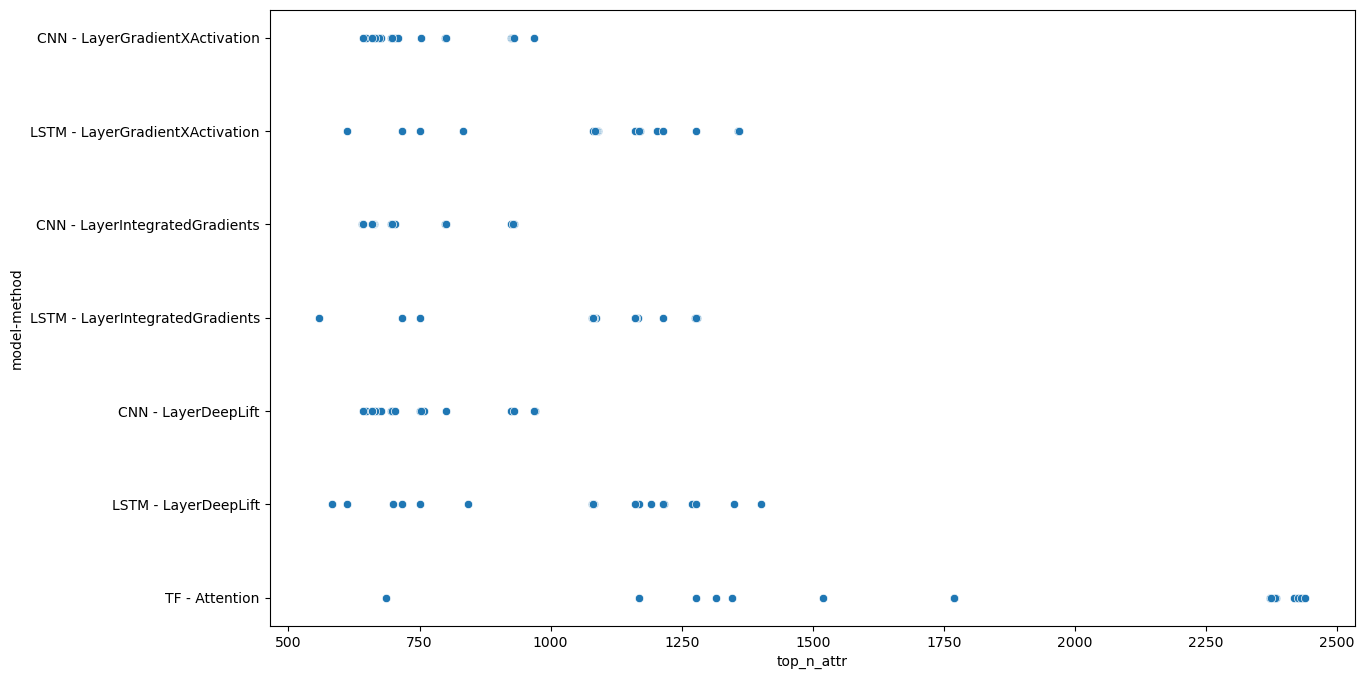

In [51]:
plt.figure(figsize=(14,8))
ax = sns.scatterplot(data=exploded_df[exploded_df["class"] == "Human"], x="top_n_attr", y="model-method")
plt.show()

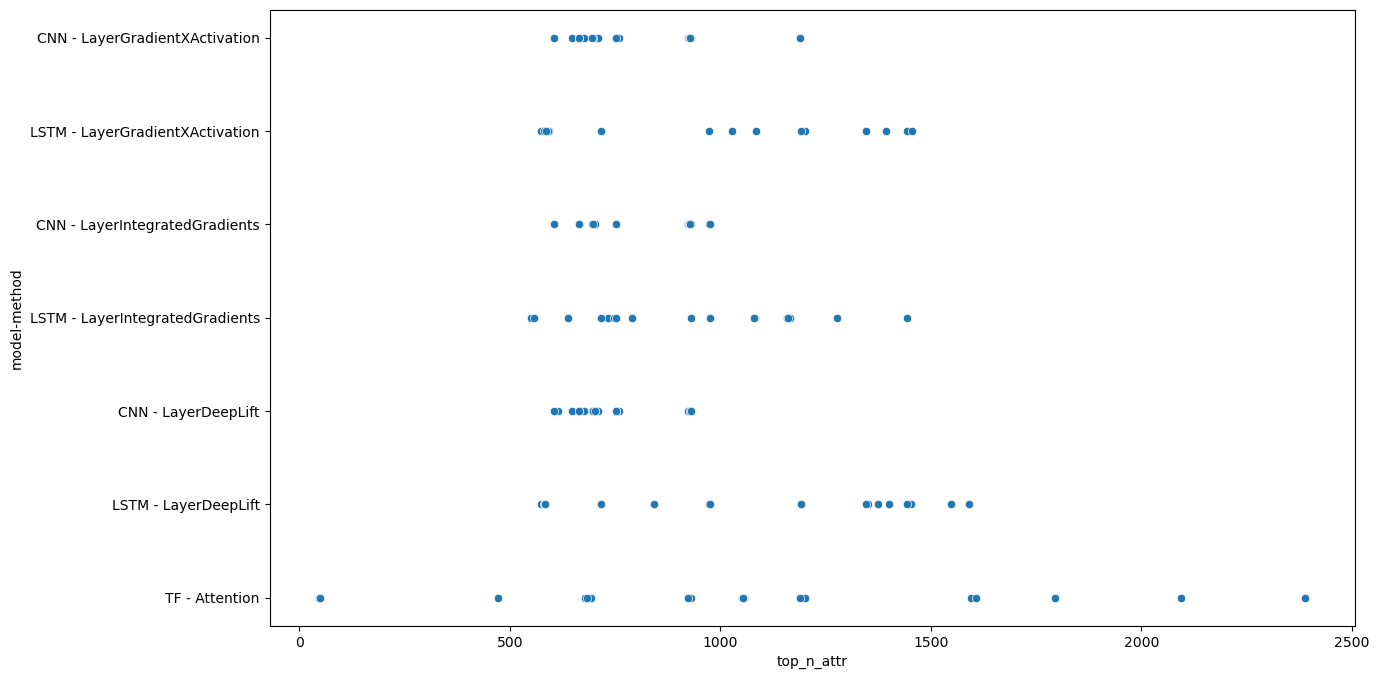

In [52]:
plt.figure(figsize=(14,8))
ax = sns.scatterplot(data=exploded_df[exploded_df["class"] == "Boar"], x="top_n_attr", y="model-method")
plt.show()

### LayerIntegratedGradients and LayerDeepLift with different host reference sequences

In [53]:
label_groupings

{'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}

In [63]:
single_seq_attr_diff_ref_dfs = []

for key, value in label_groupings.items():
    target_value = value[0]
    print(f"Key: {key}, Value: {target_value}")
    _, target_dataset_loader = get_target_dataset_loader(target_value)
    ref_seq, ref_label = next(iter(target_dataset_loader))
    
    single_seq_attr_diff_ref_dfs.append({
        "model": "CNN",
        "method": "LayerIntegratedGradients",
        "ref_class": key,
        "attr_df": compute_lig_attributions(cnn_model, [human_input], target=1, reference_seq=reference_seq)
    })

    single_seq_attr_diff_ref_dfs.append({
        "model": "LSTM",
        "method": "LayerIntegratedGradients",
        "ref_class": key,
        "attr_df": compute_lig_attributions(lstm_model, [human_input], target=1, reference_seq=reference_seq)
    })

    single_seq_attr_diff_ref_dfs.append({
        "model": "CNN",
        "method": "LayerDeepLift",
        "ref_class": key,
        "attr_df": compute_ldeeplift_attributions(cnn_model, [human_input], target=1, reference_seq=reference_seq)
    })

    single_seq_attr_diff_ref_dfs.append({
        "model": "LSTM",
        "method": "LayerDeepLift",
        "ref_class": key,
        "attr_df": compute_ldeeplift_attributions(lstm_model, [human_input], target=1, reference_seq=reference_seq)
    })


Key: Human, Value: Human
Size Human df = (698, 6)
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/hev-aligned/../../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/hev-aligned/../../../../src/utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/hev-aligned/../../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.21 GiB (GPU 0; 12.00 GiB total capacity; 3.63 GiB already allocated; 1.56 GiB free; 8.80 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [64]:
single_seq_attr_diff_ref_dfs

[{'model': 'CNN',
  'method': 'LayerIntegratedGradients',
  'ref_class': 'Human',
  'attr_df':    0        1         2         3         4         5         6         7     \
  0   0.0  0.00022  0.000681  0.001697  0.002299  0.003591  0.003597  0.003807   
  
         8         9     ...      2471      2472      2473      2474      2475  \
  0  0.003942  0.003922  ...  0.003357  0.002471  0.002876  0.003335  0.002292   
  
         2476     2477      2478     2479      2480  
  0  0.001654  0.00137  0.000535  0.00017  0.000041  
  
  [1 rows x 2481 columns]}]

In [65]:
# compute ranks
for entry in single_seq_attr_diff_ref_dfs:
    attr_df = entry["attr_df"]
    attr = attr_df.iloc[0, :].values
    attr_abs = np.abs(attr)
    # top 20 attr values
    entry["top_n_attr"] = np.argsort(attr_abs)[-20:]

In [57]:
df = pd.DataFrame(single_seq_attr_diff_ref_dfs)
df.drop(columns="attr_df", inplace=True)

In [58]:
df

,model,method,ref_class,top_n_attr
0,CNN,LayerIntegratedGradients,Human,"[930, 663, 641, 927, 643, 662, 697, 925, 699, ..."


In [59]:
df["model-method"] = df["model"] + " - " + df["method"]

In [60]:
df

,model,method,ref_class,top_n_attr,model-method
0,CNN,LayerIntegratedGradients,Human,"[930, 663, 641, 927, 643, 662, 697, 925, 699, ...",CNN - LayerIntegratedGradients


In [61]:
df["model-method"].unique()

array(['CNN - LayerIntegratedGradients'], dtype=object)

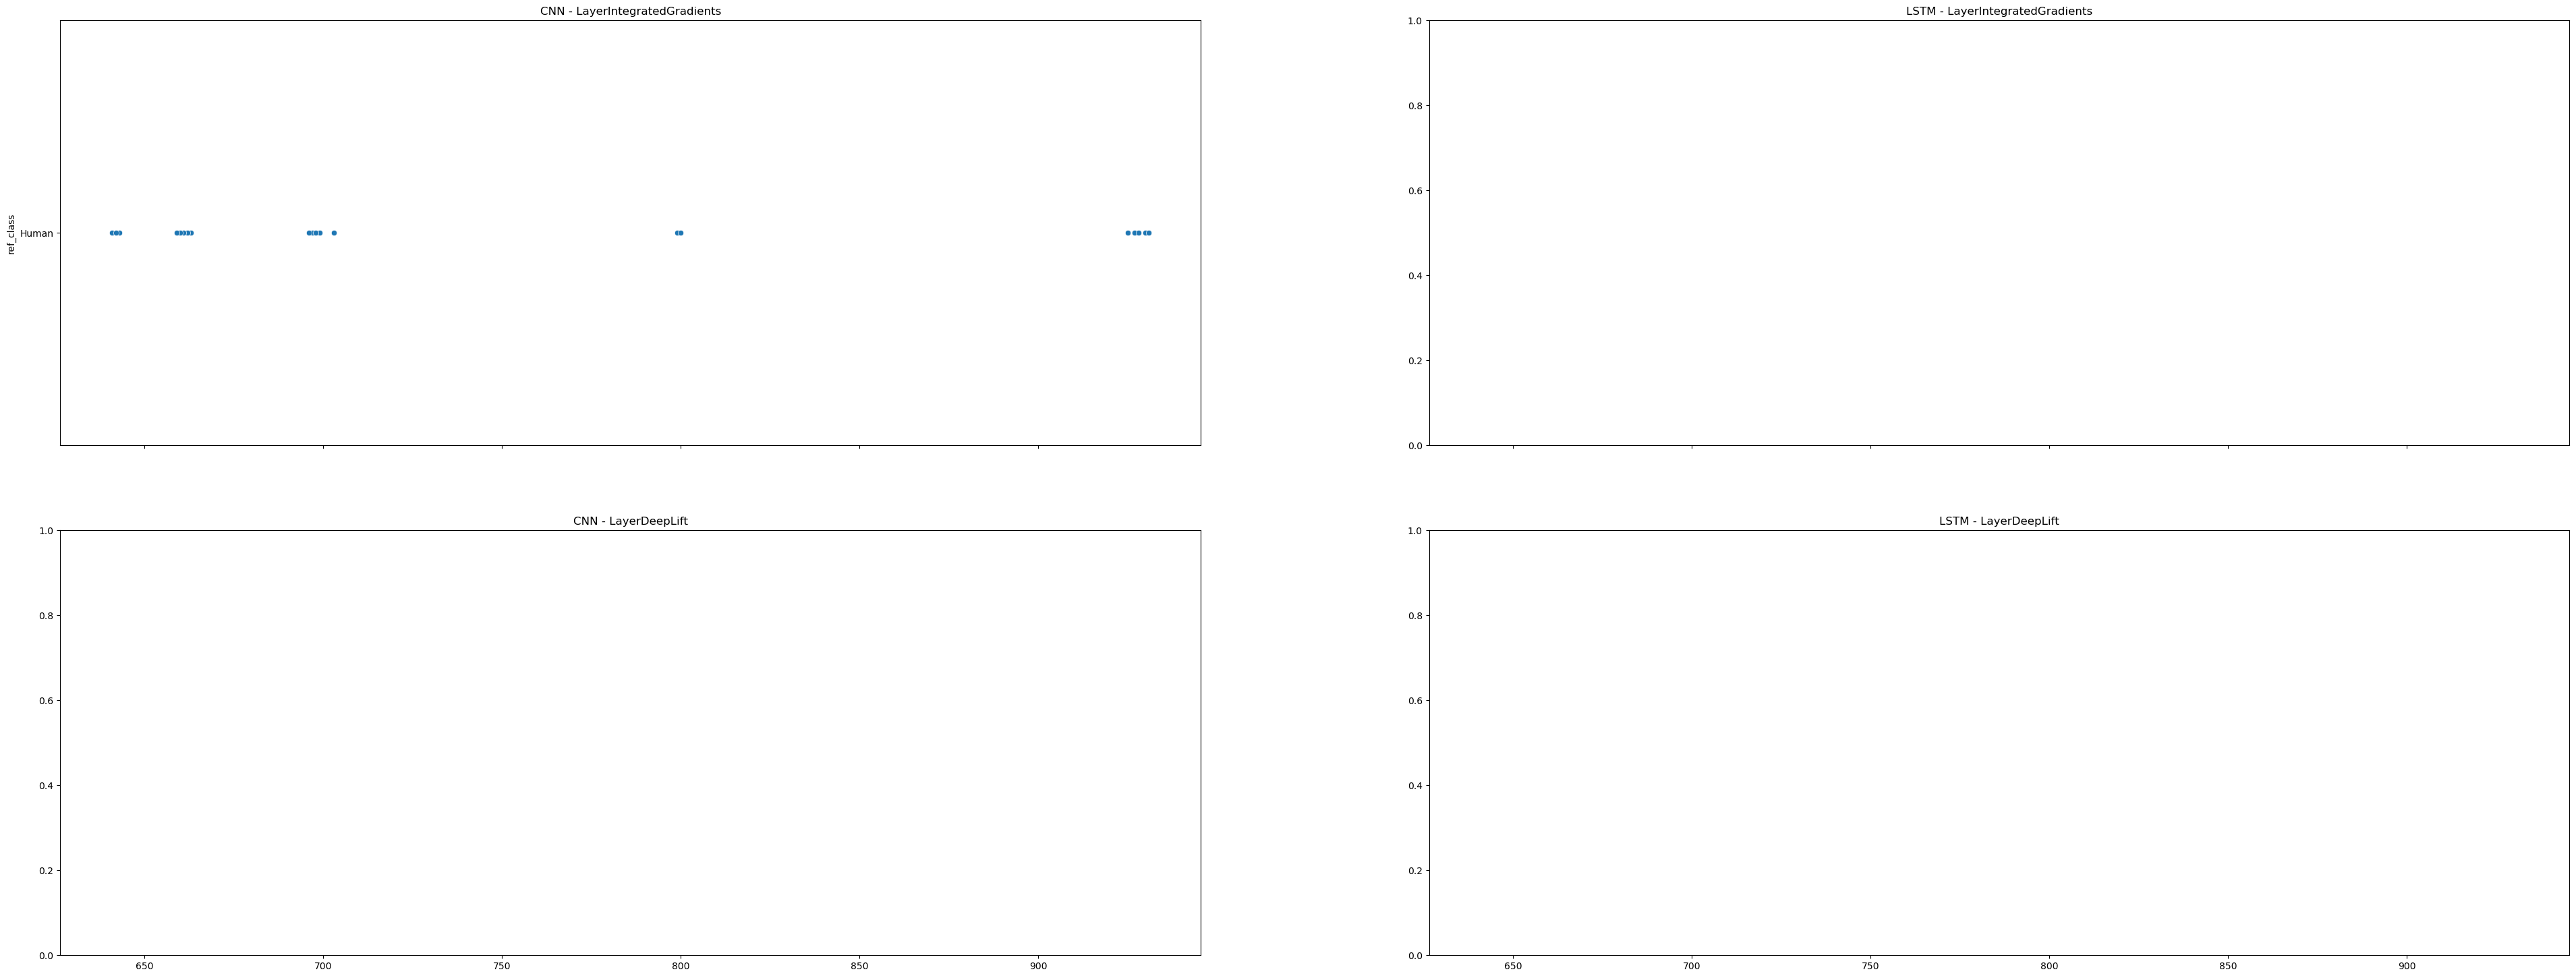

In [62]:
figs, axs = plt.subplots(2, 2, figsize=(48, 18), sharex=True)

def draw_subplot(model_method, ax):
    sub_df = df[df["model-method"] == model_method]
    exploded_sub_df = sub_df.explode("top_n_attr")
    sns.scatterplot(data=exploded_sub_df, x="top_n_attr", y="ref_class", ax=ax)
    ax.set_title(f"{model_method}")


# 0, 0: CNN - LayerIntegratedGradients
draw_subplot("CNN - LayerIntegratedGradients", axs[0, 0])

# 0, 1: LSTM - LayerIntegratedGradients
draw_subplot("LSTM - LayerIntegratedGradients", axs[0, 1])

# 1, 0: CNN - LayerDeepLift
draw_subplot("CNN - LayerDeepLift", axs[1, 0])

# 1, 1: LSTM - LayerDeepLift
draw_subplot("LSTM - LayerDeepLift", axs[1, 1])


plt.show()